In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

trainData = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
testData = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [2]:
trainData.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
testData.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Here, we see that the test dataset is only useful for the competition organizers, but we cannot use it due to the absence of a "label" column. To address this, I will split the training dataset into training and testing portions.

In [4]:
trainData = np.array(trainData)
rows, columns = trainData.shape
np.random.shuffle(trainData) # shuffle before splitting into dev and training sets

print(f"rows: {rows} , columns: {columns}")

rows: 42000 , columns: 785


In [5]:
testData = trainData[0:2000].T
testLabels = testData[0]
testPixels = testData[1:columns+1]
testPixels = testPixels / 255.

trainData = trainData[2000:rows].T
trainLabels = trainData[0]
trainPixels = trainData[1:columns+1]
trainPixels = trainPixels / 255.
_,rows_train = trainPixels.shape

In [6]:
print(testLabels)
print(f"shape : {testLabels.shape}")

[9 1 9 ... 8 5 1]
shape : (2000,)


In [7]:
print(testPixels)
print(f"shape: {testPixels.shape}")
print(f"shape: {testPixels[:,1].shape}")

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
shape: (784, 2000)
shape: (784,)


In [8]:
print(trainLabels)
print(f"shape : {trainLabels.shape}")

[7 2 3 ... 6 5 9]
shape : (40000,)


In [9]:
print(trainPixels)
print(f"shape: {trainPixels.shape}")
print(f"shape: {trainPixels[:,1].shape}")

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
shape: (784, 40000)
shape: (784,)


This all checks out so we can move on to building our network.

In [10]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

In [11]:
def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / rows_train * dZ2.dot(A1.T)
    db2 = 1 / rows_train * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / rows_train * dZ1.dot(X.T)
    db1 = 1 / rows_train * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

In [12]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [13]:
W1, b1, W2, b2 = gradient_descent(trainPixels, trainLabels, 0.10, 500)

Iteration:  0
[2 2 2 ... 2 1 4] [7 2 3 ... 6 5 9]
0.09675
Iteration:  10
[3 5 3 ... 3 1 6] [7 2 3 ... 6 5 9]
0.198125
Iteration:  20
[6 0 3 ... 3 0 6] [7 2 3 ... 6 5 9]
0.322275
Iteration:  30
[6 0 3 ... 3 0 9] [7 2 3 ... 6 5 9]
0.379
Iteration:  40
[6 0 3 ... 3 0 9] [7 2 3 ... 6 5 9]
0.4206
Iteration:  50
[6 0 3 ... 3 0 9] [7 2 3 ... 6 5 9]
0.452975
Iteration:  60
[8 0 3 ... 3 0 9] [7 2 3 ... 6 5 9]
0.48655
Iteration:  70
[4 0 3 ... 3 0 9] [7 2 3 ... 6 5 9]
0.52315
Iteration:  80
[9 0 3 ... 2 0 9] [7 2 3 ... 6 5 9]
0.558225
Iteration:  90
[9 3 3 ... 2 0 9] [7 2 3 ... 6 5 9]
0.586975
Iteration:  100
[9 3 3 ... 2 7 9] [7 2 3 ... 6 5 9]
0.614525
Iteration:  110
[9 3 3 ... 2 7 9] [7 2 3 ... 6 5 9]
0.6368
Iteration:  120
[9 3 3 ... 2 7 4] [7 2 3 ... 6 5 9]
0.657
Iteration:  130
[9 3 3 ... 2 7 4] [7 2 3 ... 6 5 9]
0.67415
Iteration:  140
[9 3 3 ... 2 7 4] [7 2 3 ... 6 5 9]
0.688875
Iteration:  150
[9 3 3 ... 2 7 4] [7 2 3 ... 6 5 9]
0.703075
Iteration:  160
[9 3 3 ... 2 7 4] [7 2 3 ... 6 5 

In [14]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = trainPixels[:, index, None]
    prediction = make_predictions(trainPixels[:, index, None], W1, b1, W2, b2)
    label = trainLabels[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [9]
Label:  7


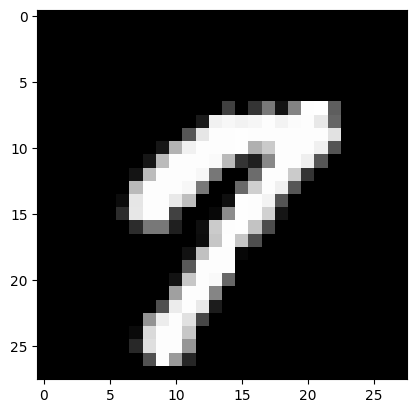

Prediction:  [2]
Label:  2


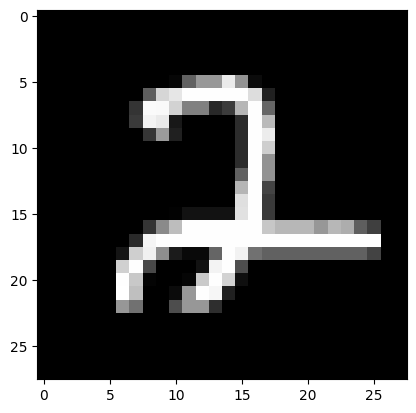

In [15]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)